In this tutorial, we compare the prediction sets estimated by the
RCPS and RCR methods implemented in MAPIE on a toy two-dimensional dataset.

Throughout this tutorial, we will answer the following questions:

-  How does the threshold \lambda varies according to the desired risk  ?

-  Is the chosen conformal method well calibrated (i.e. does the actual risk equal to the desired one) ?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB

from mapie.multi_label_classification import MapieMultiLabelClassifier

%matplotlib inline

# 1. Contruction of the dataset

We use a two-dimensional toy dataset with three possible labels. The idea is to create a triangle where the observations on the edges have only one label, those on the vertices have two labels (those of the two edges) and the center have all the labels

In [2]:
centers = [(0, 10), (-5, 0), (5, 0), (0, 5), (0, 0), (-4, 5), (5, 5)]
covs = [
    np.eye(2)**2, np.eye(2)**2, np.eye(2)**2, np.diag([5, 5]), np.diag([3, 1]),
    np.array([
        [4, 3],
        [3, 4]
    ]),
    np.array([
        [3, -2],
        [-2, 3]
    ]),
    
]

x_min, x_max, y_min, y_max, step = -15, 15, -5, 15, 0.1
n_samples = 800
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
classes = [[1, 0, 1], [1, 1, 0], [0, 1, 1], [1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1]]
y = np.vstack([np.full((n_samples, 3), i) for i in classes])

X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)

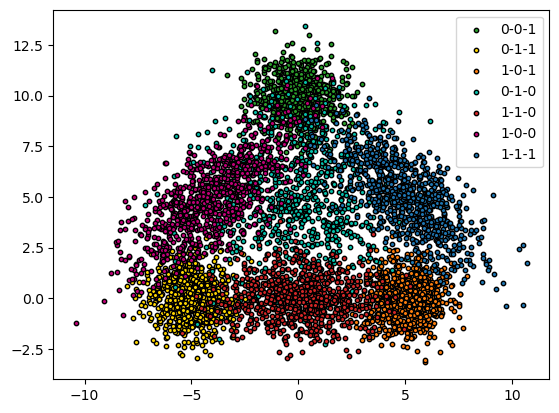

In [3]:
colors = {
    (0, 0, 1): {"color": "#1f77b4", "label": "0-0-1"},
    (0, 1, 1): {"color": "#ff7f0e", "label": "0-1-1"},
    (1, 0, 1): {"color": "#2ca02c", "label": "1-0-1"},
    (0, 1, 0): {"color": "#d62728", "label": "0-1-0"},
    (1, 1, 0): {"color": "#ffd700", "label": "1-1-0"},
    (1, 0, 0): {"color": "#c20078", "label": "1-0-0"},
    (1, 1, 1): {"color": "#06C2AC", "label": "1-1-1"}
}

for i in range(7):
    plt.scatter(
        X[n_samples * i:n_samples * (i + 1), 0],
        X[n_samples * i:n_samples * (i + 1), 1],
        color=colors[tuple(y[n_samples * i])]["color"],
        marker='o',
        s=10,
        edgecolor='k'
    )
plt.legend([c["label"] for c in colors.values()])

# 2. Fitting MapieMultiLabelClassifier

MapieMultiLabelClassifier will be fitted with RCPS and CRC methods. For the RCPS method, we will test all three Upper Confiance Bound (Hoeffding, Bernstein and Waudby-Smith–Ramdas).
The two methods give two different guaranties on the risk:


- RCPS: $\mathbb{P}(R(\mathcal{T}_{\hat{\lambda}}) \leq \alpha ) \geq 1 - \delta$ where $R(\mathcal{T}_{\hat{\lambda}})$ is the risk we want to control and $\alpha$ is the desired risk

- CRC: $ \mathbb{E}\left[L_{n+1}(\hat{\lambda})\right] \leq \alpha $ where $[L_{n+1}(\hat{\lambda})$ is the risk of a new observation and $\alpha$ is the desired risk
  

In both cases, the objective of the method is to find the optimal value of $\lambda$ (threshold above which we consider a label as being present) such that the recall on the test points is at least equal to the required recall.


In [4]:
method_params = {
    "RCPS - Hoeffding": ("rcps", "hoeffding"),
    "RCPS - Berstein": ("rcps", "bernstein"),
    "RCPS - WSR": ("rcps", "wsr"),
    "CRC": ("crc", None)
}


In [5]:
clf = MultiOutputClassifier(GaussianNB()).fit(X_train, y_train)

In [6]:
alpha = np.arange(0.01, 1, 0.01)
y_pss, recalls, thresholds, r_hats, r_hat_pluss = {}, {}, {}, {}, {}
y_test_repeat = np.repeat(y_test[:, :, np.newaxis], len(alpha), 2)
for i, (name, (method, bound)) in enumerate(method_params.items()):

    mapie =  MapieMultiLabelClassifier(estimator=clf, method=method, metric_control='recall')
    mapie.fit(X_cal, y_cal)
    
    _, y_pss[name] = mapie.predict(X_test, alpha=alpha, bound=bound, delta=.1)
    recalls[name] = ((y_test_repeat * y_pss[name]).sum(axis=1) / y_test_repeat.sum(axis=1)).mean(axis=0)
    thresholds[name] = mapie.lambdas_star
    r_hats[name] = mapie.r_hat
    r_hat_pluss[name] = mapie.r_hat_plus

/Users/sofianeziane/Documents/Mapie/MAPIE/mapie/multi_label_classification.py:269: UserWarning: WARNING: you are using crc method, hence even if the delta is not ``None``, it won't betaken into account
  warnings.warn(


# 3. Results

To check the results of the methods, we propose to types of plots:

- Plots where the level of confidence is varied. Here two metrics are plotted for each method and for each UCB
    - The actual recall (which should be always near to the required one): we can see that they are close to each other. 
    - The value of the threshold: we see that the threshold is decreasing as $1 - \alpha$ increases, which is what we expected because a smaller threshold will give you larger prediction sets, hence a larger recall.

- Plots where we choose a specific risk value (0.1 in our case) and look at the average risk, the UCB of the risk (for RCPS methods) and the choice of the thresold $\lambda$
    - We can see that among the RCPS methods, the Bernstein method is the one who gives  the best results as for a given value of $\alpha$ as we are above the required recall but with a larger value of $\lambda$ than the two others bounds.
    - The CRC method gives the best results

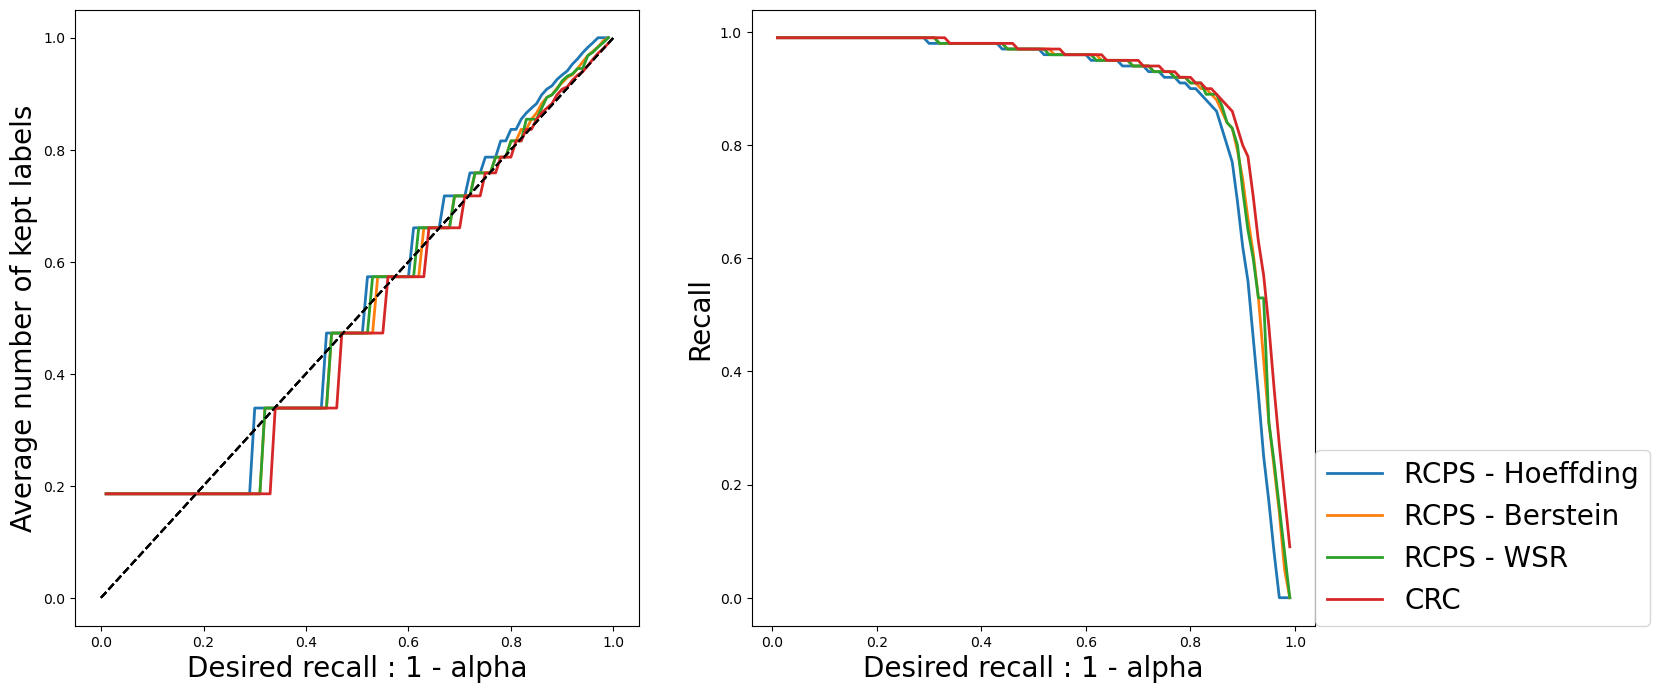

In [7]:
vars_y = [recalls, thresholds]
labels_y = ["Average number of kept labels", "Recall", "Thresold"]

fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, (method, bound) in method_params.items():
        axs[i].plot(1 - alpha, var[name], label=name, linewidth=2)
        if i == 0:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Desired recall : 1 - alpha", fontsize=20)
    axs[i].set_ylabel(labels_y[i], fontsize=20)
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

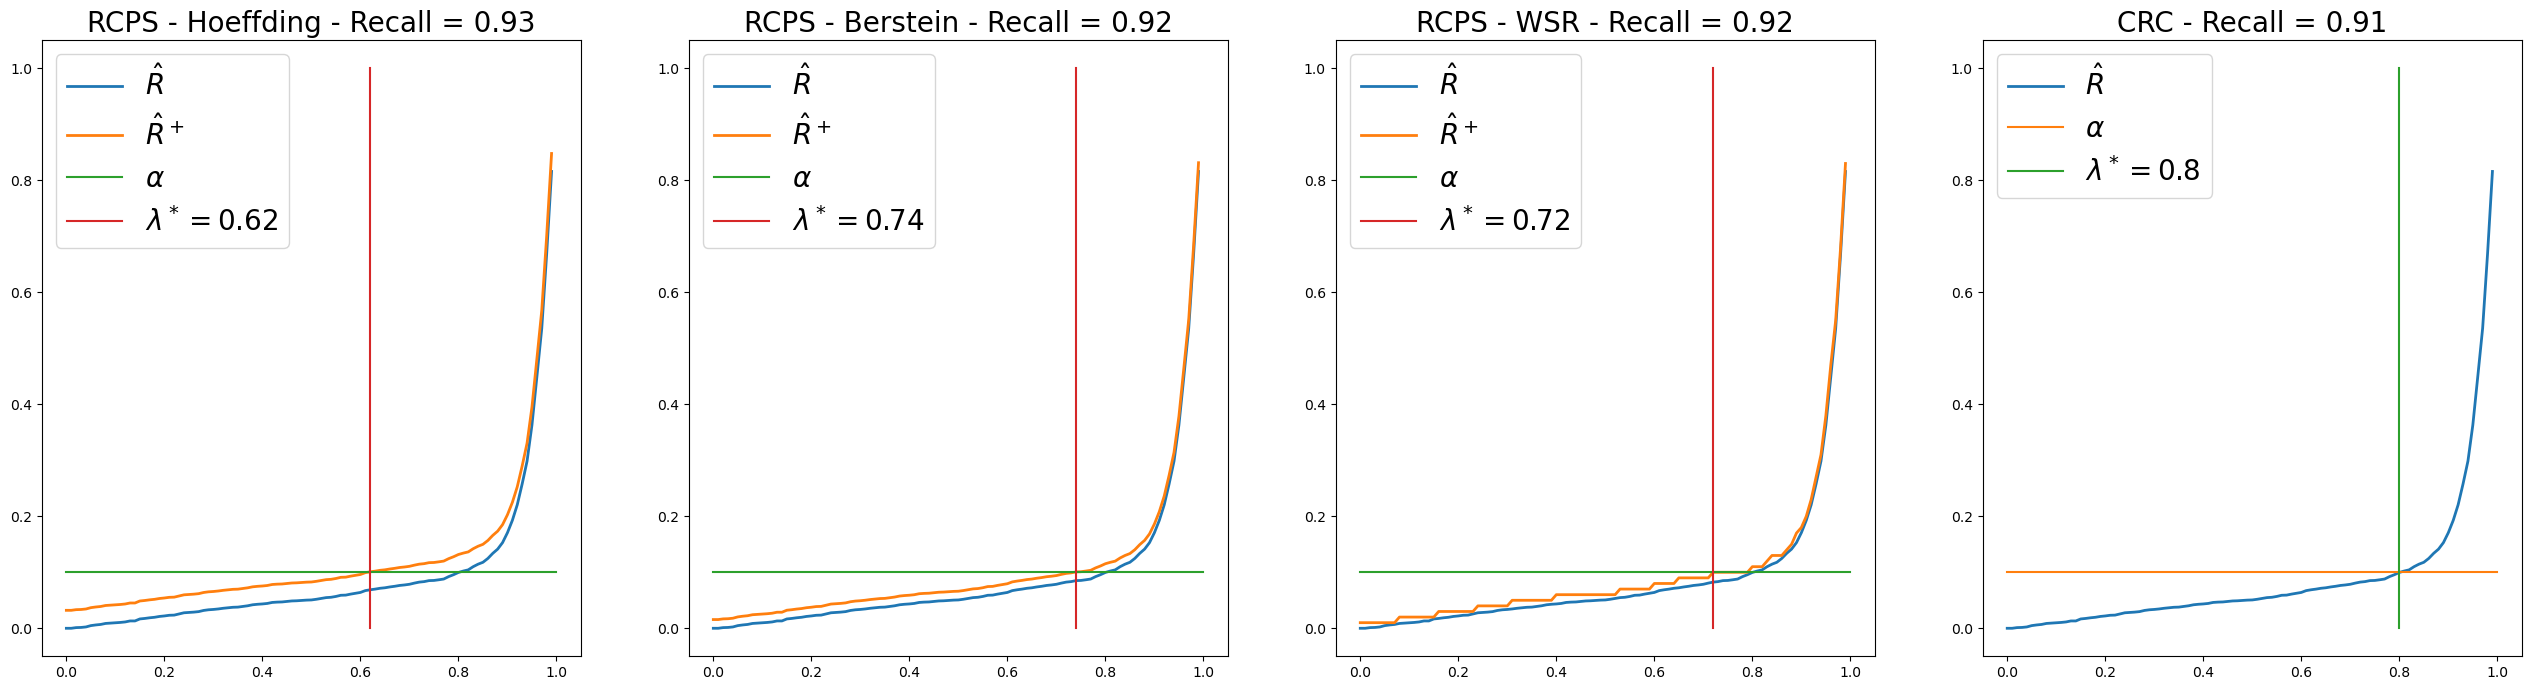

In [8]:
fig, axs = plt.subplots(1, len(method_params), figsize=(8*len(method_params), 8))
for i, (name, (method, bound)) in enumerate(method_params.items()):
    axs[i].plot(
        [l / mapie.n_lambdas for l in range(mapie.n_lambdas)],
        r_hats[name], label=r"$\hat{R}$", linewidth=2
    )
    if name != "CRC":
        axs[i].plot(
            [l / mapie.n_lambdas for l in range(mapie.n_lambdas)],
            r_hat_pluss[name], label=r"$\hat{R}^+$", linewidth=2
        )
    axs[i].plot([0, 1], [alpha[9], alpha[9]], label=r"$\alpha$")
    axs[i].plot(
        [thresholds[name][9], thresholds[name][9]], [0, 1],
        label=f"$\lambda^* = {thresholds[name][9]}$"
    )
    axs[i].legend(fontsize=20)
    axs[i].set_title(f"{name} - Recall = {round(recalls[name][9], 2)}", fontsize=20)

# 4 Learn Then Test

In this part, we will use learn then test to control precision score. At the opposite of the 2 previous method, ltt can handle non-monotonous loss and so it uses multiple hypothesis to control risk. This is why the output of this procedure isn't reduce to one value of $\lambda$.

- LTT:  $\mathbb{P}(R(\mathcal{T}_{\lambda}) \leq \alpha ) \geq 1 - \delta$ where $R(\mathcal{T}_{\lambda})$ is the risk we want to control for each $\lambda$ that satisfy fwer control and $\alpha$ is the desired risk



In [9]:
mapie =  MapieMultiLabelClassifier(estimator=clf, method='ltt', metric_control='precision')
mapie.fit(X_cal, y_cal)

/Users/sofianeziane/Documents/Mapie/MAPIE/mapie/control_risk/risks.py:118: RuntimeWarning: invalid value encountered in true_divide
  risks = 1 - _true_positive(y_pred_th, y_repeat)/y_pred_th.sum(axis=1)


MapieMultiLabelClassifier(estimator=MultiOutputClassifier(estimator=GaussianNB()),
                          method='ltt', metric_control='precision')

In [10]:
alpha = 0.1
_, y_ps = mapie.predict(X_test, alpha = alpha, delta = 0.1)


/Users/sofianeziane/Documents/Mapie/MAPIE/mapie/multi_label_classification.py:420: UserWarning: WARNING: you are using ltt method hence even if bound is not ``None``, it won't betaken into account.
  warnings.warn(


/var/folders/9b/lxd5fc7j2hsgkd2x9m88vxpr0000gn/T/ipykernel_31671/3032881146.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lambdas = mapie.lambdas[mapie.valid_index]


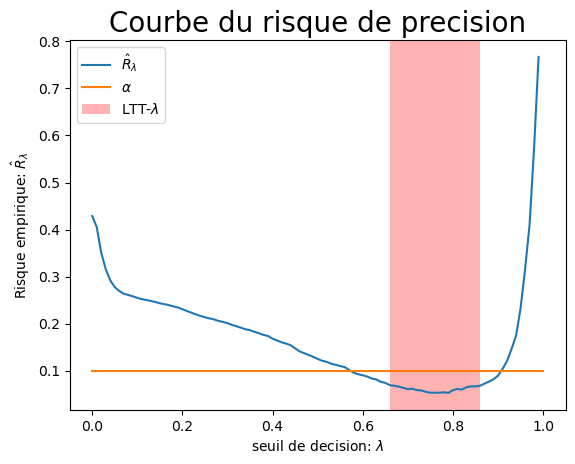

In [13]:
valid_index = mapie.valid_index
lambdas = mapie.lambdas[mapie.valid_index]
mini = lambdas[np.argmin(lambdas)]
maxi = lambdas[np.argmax(lambdas)]
mapie.lambdas[valid_index[0]]
plt.plot(mapie.lambdas, mapie.r_hat, label=r"$\hat{R}_\lambda$")
plt.plot([0, 1], np.array([alpha, alpha]), label=r"$\alpha$")
plt.axvspan(mini, maxi, facecolor='red', alpha=0.3, label=r"LTT-$\lambda$")
plt.xlabel(r"seuil de decision: $\lambda$")
plt.ylabel(r"Risque empirique: $\hat{R}_\lambda$")
plt.title(f"Courbe du risque de precision", fontsize=20)
plt.legend()  
